# Анализируем вакансии Data Engineer используя HeadHunter API

## Подключаем библиотеки, объявляем функции

In [1]:
import json
from collections import namedtuple
from time import sleep

import pandas as pd
import requests


def get_vacancy_props(vacancy_id):
    """
    Возвращает требуемый стаж работы и навыки.
    """
    skills = []
    vacancy_url = 'https://api.hh.ru/vacancies/'
    vacancy_data = requests.get(url=(vacancy_url + vacancy_id)).json()
    sleep(1)  # Задержка, чтобы не ддосить api
    for skill in vacancy_data['key_skills']:
        skills.append(skill['name'])
    return vacancy_data['experience']['id'], skills if skills else ['Не указано']


def get_employer_industries(employer_id):
    """
    Возвращает отрасли деятельности работодателя.
    """
    industries = []
    employer_url = 'https://api.hh.ru/employers/'
    employer_data = requests.get(url=(employer_url + employer_id)).json()
    sleep(1)  # Задержка, чтобы не ддосить api
    for industry in employer_data['industries']:
        industries.append(industry['name'])
    return industries if industries else ['Не указано']


def get_vacancies(page):
    """
    Возвращает вакансии постранично.
    """
    url = 'https://api.hh.ru/vacancies'
    params = dict(
        text='name:(data and engineer) or name:(data and инженер) or name:(инженер and данных) or name:(engineer and данных)',
        area='113',  # Россия
        archived='false',  # Только действующие
        per_page='100',
        page=page,
    )
    data = requests.get(url=url, params=params).json()
    return data['items']

## Пользуясь API HeadHunter, достаем вакансии в словарь vacancies
__!!! Долгая операция - 20 мин.!!! Пропускаем, т.к. результат в json разместил ссылкой__

In [4]:
# Vacancy = namedtuple("Vacancy", "name employer_name employer_place industries experience skills")
# vacancies = []
# Заранее знаю, что будет 5 страниц
# for i in range(5):
#     for vacancy in get_vacancies(i):
#         vacancy_prop = get_vacancy_props(vacancy['id'])
#         vacancies.append(
#             Vacancy(
#                 name=vacancy['name'],
#                 employer_name=vacancy['employer']['name'],
#                 employer_place=vacancy['area']['name'],
#                 industries=get_employer_industries(vacancy['employer']['id']),
#                 experience=vacancy_prop[0],
#                 skills=vacancy_prop[1]
#             )
#         )
# with open('vacancies.json', 'w', encoding='utf-8') as f:
#     json.dump(vacancies, f)

## Помещаем vacancies в таблицу Pandas

In [17]:
# pd_vacancies = pd.read_json('vacancies.json')
pd_vacancies = pd.read_json('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/pO5rRKMNemhMfA')
pd_vacancies.columns = ["name", "employer_name", "employer_place", "industries", "experience", "skills"]
pd_vacancies.head()

,name,employer_name,employer_place,industries,experience,skills
0,Аналитик данных (Data Engineer),СБЕР,Самара,[Банк],between1And3,[Не указано]
1,Data Engineer,Апптимизм,Москва,"[Интернет-компания (поисковики, платежные сист...",noExperience,"[SQL, Python, SCALA, Hadoop, Kafka]"
2,Data Engineer,Велесстрой,Москва,[Строительство коммерческих объектов (торговые...,between1And3,"[СУБД MS SQL, MongoDB, Hadoop, ETL, MS PowerBI..."
3,Data Engineer,Marfatech,Москва,[Не указано],between1And3,"[Python, SQL]"
4,Data engineer,Яндекс,Москва,"[Интернет-компания (поисковики, платежные сист...",between3And6,"[Python, Hadoop, Hive, SQL, Pandas]"


## Общее количество вакансий

In [19]:
len(pd_vacancies)

448

## Требуемый стаж работы по специальности

<AxesSubplot:>

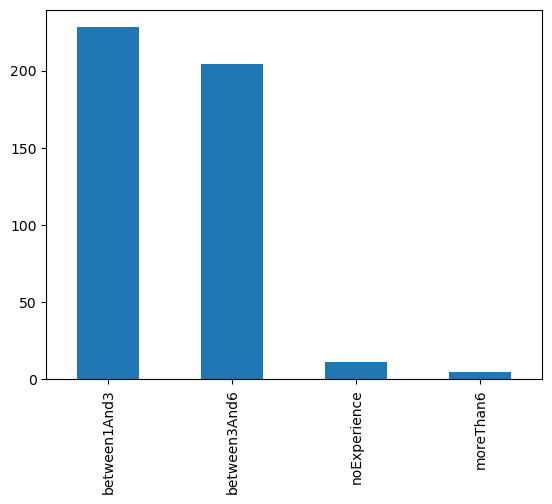

In [20]:
%matplotlib inline
experience_column = pd_vacancies["experience"].apply(pd.Series)
experience_count = experience_column.iloc[:, 0].value_counts()
experience_count.plot(kind="bar")

## Требуемые навыки (20 наиболее востребованных)

<AxesSubplot:>

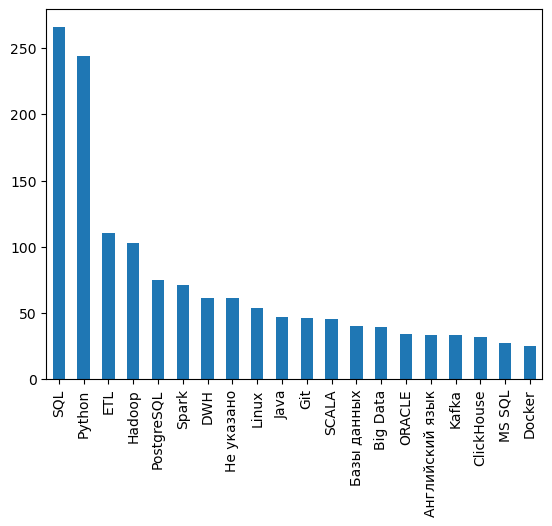

In [21]:
skills_column = pd_vacancies["skills"].apply(pd.Series)
skills_count = skills_column.stack().value_counts()
skills_count[:20].plot(kind="bar")

## Распределение вакансий по городам (20 наиболее частых)

<AxesSubplot:>

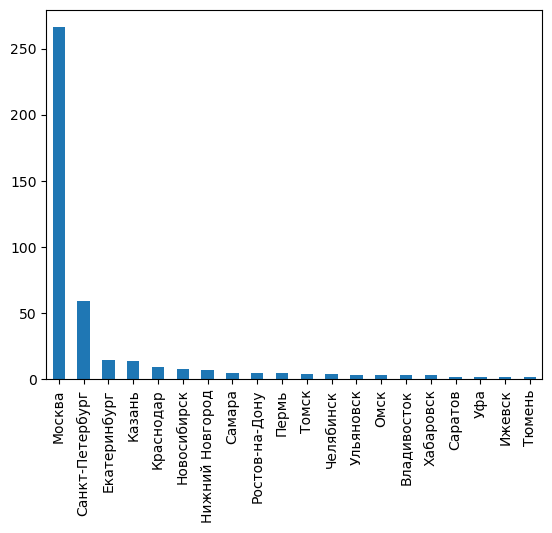

In [22]:
employer_place_column = pd_vacancies["employer_place"].apply(pd.Series)
employer_place_count = employer_place_column.stack().value_counts()
employer_place_count[:20].plot(kind="bar")

## Распределение вакансий по отраслям (20 наиболее частых)

<AxesSubplot:>

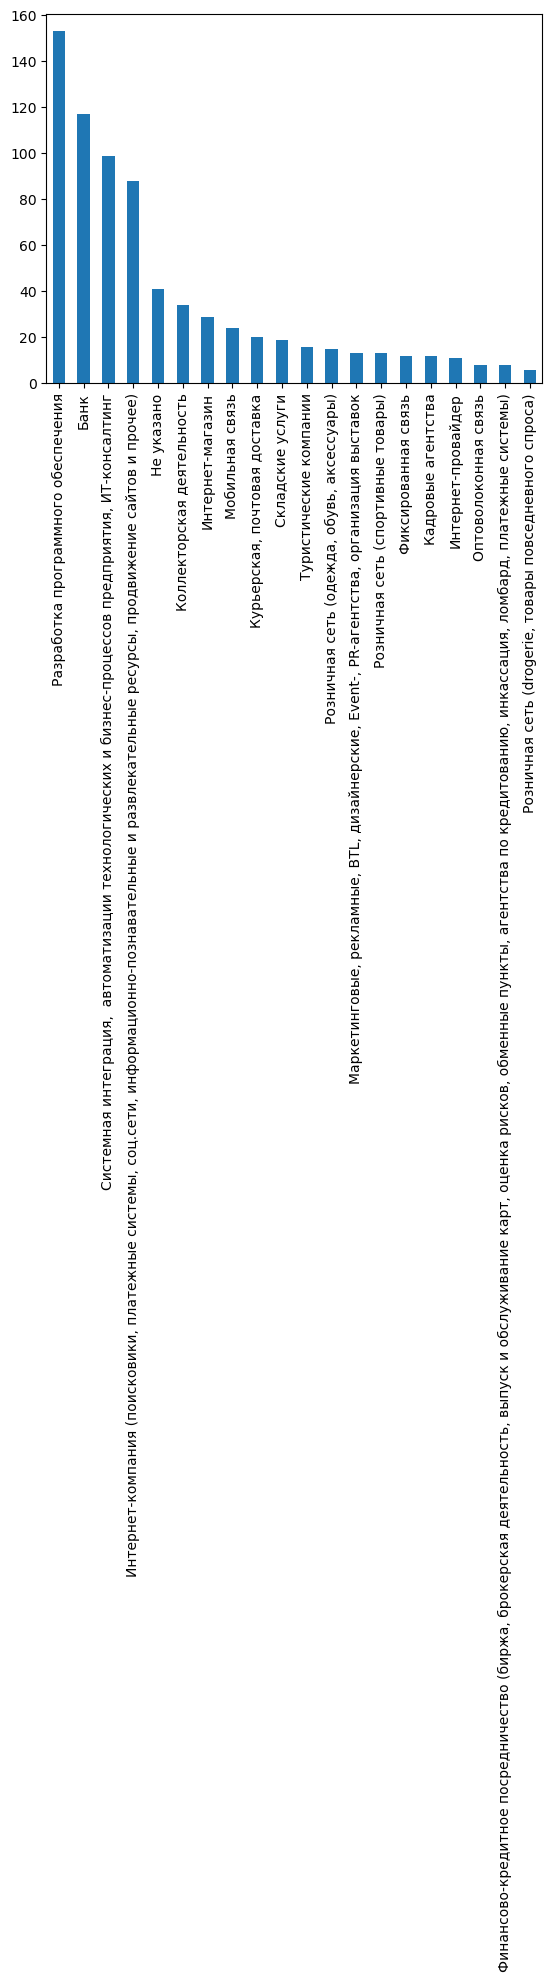

In [23]:
industries_column = pd_vacancies["industries"].apply(pd.Series)
industries_count = industries_column.stack().value_counts()
industries_count[:20].plot(kind="bar")

## Исходя из полученных результатов нужно накапливать опыт и изучать технологии:

## Базы данных, Python, ETL, DWH, Hadoop, Spark, ClickHouse, Kafka, Linux, Docker, Git